<img src="static/images/datachain-logo.png" alt="Dataset" style="width: 200px;"/>

# 🚀 Run Inference Jobs using Datachain (scalable batch scoring)

In this tutorial, you'll learn how to run inference jobs on a large dataset using **[Datachain](https://github.com/iterative/datachain)** in batch processing. Batch inference is useful when you have a pre-trained model and want to make predictions on a dataset without needing real-time processing. **[Datachain](https://github.com/iterative/datachain)** provides a convenient way to run inference jobs on datasets stored in DataChain.

## 📋  Agenda

1. Load Pre-trained Model
2. Define Inference Classes
3. Run Inference
4. Save Predictions

## 🛠 Prerequisites

Before you begin, ensure you have:

- **[Datachain](https://github.com/iterative/datachain)** installed in your environment. 
- The necessary dependencies installed, including PyTorch and the required libraries.
- Access to the pre-trained model file `model.pth`.
- Access to the test dataset `fashion-test` for inference.

In [19]:
%load_ext autoreload
%autoreload 2

import os
import pathlib
import torch

from datachain import C, DataChain, DataModel
from datachain.lib.image import convert_image
from torch import optim

from src.train import CNN, transform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 📥 Load Model (pre-trained)

- Load the pre-trained model weights and optimizer state.
- Create an instance of the `CNN` model.
- Create an optimizer using `optim.SGD`.


In [20]:
#### Load Pre-trained Model  #####

checkpoint = torch.load("model.pth")
CLASSES = checkpoint["classes"]
NUM_CLASSES = len(CLASSES)

model = CNN(NUM_CLASSES)
optimizer = optim.SGD(model.parameters(), lr=0.001)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

print(CLASSES)
print(NUM_CLASSES)
print(model, optimizer)

['Casual', 'Ethnic', 'Sports', 'Formal', 'Party', 'Smart Casual', 'Travel', 'nan']
8
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=8, bias=True)
) SGD (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    nesterov: False
    weight_decay: 0
)


By following these steps, you can easily load a pre-trained model and its associated optimizer state in PyTorch. This allows you to leverage the learned weights and continue training or perform inference without starting from scratch.

# ✅ Run Inference & Save Predictions

- Load the `fashion-test` dataset.
- Apply filters to select only 'Coffee' category images with non-empty `front_back` values.
- Use `map()` to apply the `InferenceMapper` to each image in the dataset.
- The `InferenceMapper` takes the image binary file as input and outputs the predicted class, probability, and label.
- The `save()` method is used to save the dataset with the predicted values as `fashion-predictions`.

## Define the inference classes

In [21]:
#### Inference #####

class Predictions(DataModel):
    pred_class: int
    pred_proba: float
    pred_label: str

class InferenceMapper():

    def __init__(self, model, classes):
        self.model = model
        self.classes = classes 
        
        self.model.eval()

    def predict(self, file) -> Predictions:

        img_raw = file.get_value()
        img = convert_image(img_raw, transform=transform).unsqueeze(0)
        
        with torch.no_grad():
            # emb = model(img)
            outputs = self.model(img)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_classes = torch.max(probs, 1)

        return Predictions(
            pred_class=predicted_classes.item(),
            pred_proba=confidence.item(),
            pred_label=self.classes[predicted_classes.item()]
        )

inference_eng = InferenceMapper(model, CLASSES) 

- Define a `Predictions` class that inherits from `Feature` to store the predicted class, probability, and label.
- Define an `InferenceMapper` class to perform the inference logic.

## Run Inference

In [22]:
(
    DataChain.from_dataset("fashion-test")
    .map(predictions=lambda file: inference_eng.predict(file), output=Predictions)
    .save("fashion-predictions")
    .show()
)

Download: 0.00B [00:00, ?B/s]
Download: 1.21MB [00:00, 12.6MB/s]]
Download: 2.64MB [00:00, 14.0MB/s]1 rows/s]
Processed: 302 rows [00:00, 1475.98 rows/s]
Download: 3.98MB [00:00, 12.9MB/s]0 rows/s]
Download: 5.23MB [00:00, 12.6MB/s]0 rows/s]
Download: 6.52MB [00:00, 12.9MB/s]9 rows/s]
Download: 7.90MB [00:00, 13.4MB/s]9 rows/s]
Download: 9.18MB [00:00, 13.3MB/s]10 rows/s]
Download: 10.5MB [00:00, 13.3MB/s]83 rows/s]
Download: 11.7MB [00:00, 13.1MB/s]61 rows/s]
Download: 13.0MB [00:01, 13.0MB/s]19 rows/s]
Download: 14.2MB [00:01, 11.1MB/s]80 rows/s]
Download: 15.6MB [00:01, 12.0MB/s]60 rows/s]
Download: 17.0MB [00:01, 12.8MB/s]27 rows/s]
Download: 18.3MB [00:01, 13.1MB/s]15 rows/s]
Download: 19.7MB [00:01, 13.5MB/s]71 rows/s]
Download: 21.0MB [00:01, 13.3MB/s]81 rows/s]
Download: 22.3MB [00:01, 13.4MB/s]49 rows/s]
Download: 23.8MB [00:01, 14.0MB/s]60 rows/s]
Download: 25.5MB [00:02, 12.9MB/s]40 rows/s]
Processed: 3095 rows [00:02, 1495.83 rows/s]


,source,parent,name,version,etag,size,vtype,location,file.source,file.parent,...,basecolour,season,year,usage,productdisplayname,filename,split,predictions.pred_class,predictions.pred_proba,predictions.pred_label
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,9733.jpg,,0x1.76bbcf3800000p+30,1694,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Green,Fall,2011.0,Casual,Indian Terrain Men Chase Green Shirts,9733.jpg,test,0,0.945018,Casual
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,37946.jpg,,0x1.76bbceb800000p+30,19733,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Mustard,Summer,2012.0,Casual,Mineral Women Mustard Tunic,37946.jpg,test,0,0.982337,Casual
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,22393.jpg,,0x1.76bbcd0800000p+30,2080,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Grey,Fall,2011.0,Casual,ADIDAS Women Verve Tee Grey T-shirt,22393.jpg,test,0,0.978819,Casual
3,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,40264.jpg,,0x1.76bbcec800000p+30,27108,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Navy Blue,Summer,2012.0,Casual,Scullers Men Navy Blue Striped T-shirt,40264.jpg,test,0,0.933966,Casual
4,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,4203.jpg,,0x1.76bbced000000p+30,1736,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Blue,Summer,2011.0,Casual,Disney Kids Boy's Blue Regatta Annual Competit...,4203.jpg,test,0,0.801145,Casual
5,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,18999.jpg,,0x1.76bbccd000000p+30,1798,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Black,Summer,2011.0,Casual,ADIDAS Originals Men Adi Firebird TT Black Jacket,18999.jpg,test,0,0.864304,Casual
6,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,24906.jpg,,0x1.76bbcd2000000p+30,1424,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Pink,Summer,2012.0,Casual,United Colors of Benetton Kids Boys Pink Print...,24906.jpg,test,0,0.886441,Casual
7,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,2128.jpg,,0x1.76bbccf000000p+30,1510,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,White,Spring,2011.0,Casual,Basics Men Red & White Slim Fit Shirt,2128.jpg,test,0,0.983772,Casual
8,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,40258.jpg,,0x1.76bbcec800000p+30,27862,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,White,Summer,2012.0,Casual,Scullers Men White & Navy Blue Shirt,40258.jpg,test,0,0.994301,Casual
9,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,12278.jpg,,0x1.76bbcc7000000p+30,1728,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Maroon,Fall,2011.0,Formal,Genesis Men Solid Maroon Shirts,12278.jpg,test,0,0.779237,Casual


[limited by 20 objects]


## Explore predictions

In [23]:
DataChain.from_dataset("fashion-predictions").select("predictions").show(10)

,predictions.pred_class,predictions.pred_proba,predictions.pred_label
0,0,0.945018,Casual
1,0,0.982337,Casual
2,0,0.978819,Casual
3,0,0.933966,Casual
4,0,0.801145,Casual
5,0,0.864304,Casual
6,0,0.886441,Casual
7,0,0.983772,Casual
8,0,0.994301,Casual
9,0,0.779237,Casual


[limited by 10 objects]


In [24]:
DataChain.from_dataset("fashion-predictions").to_pandas().shape

(3095, 32)

## Delta Updates 

- Assume we already calculated predictions for 'old' dataset (for this example assume it's all images added before 2017)
- The 'new' dataset contains some images added after 2017
- We want to calculate inference for this delta updates only

In [25]:
# Prepare datasets

old = (
    DataChain.from_dataset("fashion-product-images")
    .filter(C.masterCategory == "Apparel" and C.subCategory == "Topwear")
    .filter(C.year < 2017)
    # .limit(3)
)
print(old.to_pandas().shape)

new = (
    DataChain.from_dataset("fashion-product-images")
    .filter(C.masterCategory == "Apparel" and C.subCategory == "Topwear")
)
print(new.to_pandas().shape)

update = new.subtract(old)
print(update.to_pandas().shape)


(20933, 28)
(21395, 28)
(462, 28)


In [26]:
update_predictions = (
    update
    .map(predictions=lambda file: inference_eng.predict(file), output=Predictions)
)

df = update_predictions.to_pandas()
print(df.shape)
df.head()

Download: 0.00B [00:00, ?B/s]
Download: 1.43MB [00:00, 15.0MB/s]]
Processed: 101 rows [00:00, 1001.35 rows/s]
Download: 2.87MB [00:00, 14.2MB/s]1 rows/s]
Download: 4.40MB [00:00, 15.0MB/s]6 rows/s]
Download: 6.32MB [00:00, 15.4MB/s]0 rows/s]
Processed: 462 rows [00:00, 1082.09 rows/s]

(462, 31)


,source,parent,name,version,etag,size,vtype,location,file.source,file.parent,...,articletype,basecolour,season,year,usage,productdisplayname,filename,predictions.pred_class,predictions.pred_proba,predictions.pred_label
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,59721.jpg,,0x1.76bbcf2800000p+30,17815,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Bra,Black,Summer,2017.0,Casual,Avirate Women Black Bra,59721.jpg,0,0.907933,Casual
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,59735.jpg,,0x1.76bbcf2800000p+30,18281,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Briefs,Pink,Summer,2017.0,Casual,Avirate Pink & Black Brief,59735.jpg,0,0.877011,Casual
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,17466.jpg,,0x1.76bbccb800000p+30,10778,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Bra,White,Summer,2017.0,Casual,Beyouty Women Zena BR 01 White Bra,17466.jpg,0,0.618445,Casual
3,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,59084.jpg,,0x1.76bbcf2800000p+30,18567,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Bra,White,Summer,2017.0,Casual,Peri Peri Women White Bra,59084.jpg,0,0.812005,Casual
4,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,59090.jpg,,0x1.76bbcf2800000p+30,24103,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Bra,Black,Summer,2017.0,Casual,Peri Peri Women Black Bra,59090.jpg,0,0.829589,Casual


In [27]:
# Size of Predictions before the union (old)

DataChain.from_dataset("fashion-predictions").to_pandas().shape

(3095, 32)

In [28]:
# Add (union) new predictions and save (as a new version)

(
    DataChain.from_dataset("fashion-predictions")
    .union(update_predictions)
    .save("fashion-predictions")
)

Download: 0.00B [00:00, ?B/s]
Download: 2.27MB [00:00, 23.8MB/s]]
Processed: 168 rows [00:00, 1679.26 rows/s]
Download: 6.32MB [00:00, 22.8MB/s]8 rows/s]
Processed: 462 rows [00:00, 1604.00 rows/s]


In [29]:
# Size of Predictions after union

DataChain.from_dataset("fashion-predictions").to_pandas().shape

(3557, 32)

# 🔍 Analyze Predictions

After running inference on your test dataset and generating predictions, it's crucial to analyze the results to gain insights into your model's performance. 

DataChain provides powerful tools to filter and examine the predictions, allowing you to identify correct predictions, incorrect predictions, and explore different confidence levels. Let's break down the code:

## Show correct predictions

- Load the "fashion-predictions" dataset, which contains the predicted labels and probabilities along with the ground truth labels.
- Filter the dataset to include only the correct predictions where the predicted label (`pred_label`) matches the ground truth label (`usage`).

In [30]:
# Show correct predictions

(
    DataChain.from_dataset("fashion-predictions")
    .filter(C.usage == C.predictions.pred_label)
    .show(5)
)

,source,parent,name,version,etag,size,vtype,location,file.source,file.parent,...,basecolour,season,year,usage,productdisplayname,filename,split,predictions.pred_class,predictions.pred_proba,predictions.pred_label
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,9733.jpg,,0x1.76bbcf3800000p+30,1694,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Green,Fall,2011.0,Casual,Indian Terrain Men Chase Green Shirts,9733.jpg,test,0,0.945018,Casual
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,37946.jpg,,0x1.76bbceb800000p+30,19733,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Mustard,Summer,2012.0,Casual,Mineral Women Mustard Tunic,37946.jpg,test,0,0.982337,Casual
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,22393.jpg,,0x1.76bbcd0800000p+30,2080,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Grey,Fall,2011.0,Casual,ADIDAS Women Verve Tee Grey T-shirt,22393.jpg,test,0,0.978819,Casual
3,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,40264.jpg,,0x1.76bbcec800000p+30,27108,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Navy Blue,Summer,2012.0,Casual,Scullers Men Navy Blue Striped T-shirt,40264.jpg,test,0,0.933966,Casual
4,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,4203.jpg,,0x1.76bbced000000p+30,1736,,None,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,...,Blue,Summer,2011.0,Casual,Disney Kids Boy's Blue Regatta Annual Competit...,4203.jpg,test,0,0.801145,Casual


[limited by 5 objects]


## Show incorrect predictions

- Filter the dataset to include only the incorrect predictions where the predicted label (`pred_label`) does not match the ground truth label (`usage`).
- Assign the filtered dataset to the variable `mistakes`.

In [31]:
# Show incorrect predictions

mistakes = (
    DataChain.from_dataset("fashion-predictions")
    .filter(C.usage != C.predictions.pred_label)
    .select("file", "usage", "predictions")
)
mistakes.show(5)

,file.source,file.parent,file.name,file.size,file.version,file.etag,file.is_latest,file.last_modified,file.location,file.vtype,usage,predictions.pred_class,predictions.pred_proba,predictions.pred_label
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,12278.jpg,1728,,0x1.76bbcc7000000p+30,1,1970-01-01 00:00:00+00:00,None,,Formal,0,0.779237,Casual
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,21895.jpg,1245,,0x1.76bbcd0000000p+30,1,1970-01-01 00:00:00+00:00,None,,Ethnic,0,0.633462,Casual
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,30740.jpg,24762,,0x1.76bbcd9800000p+30,1,1970-01-01 00:00:00+00:00,None,,Ethnic,0,0.964468,Casual
3,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,22378.jpg,1609,,0x1.76bbcd0800000p+30,1,1970-01-01 00:00:00+00:00,None,,Casual,3,0.872539,Formal
4,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,59912.jpg,26151,,0x1.76bbcf2800000p+30,1,1970-01-01 00:00:00+00:00,None,,Ethnic,0,0.740864,Casual


[limited by 5 objects]


(574, 14)


<Axes: >

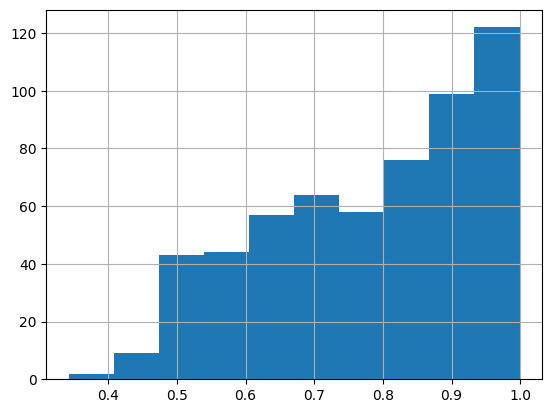

In [32]:
df = mistakes.to_pandas()
print(df.shape)

df["predictions.pred_proba"].hist()

## Analyze high-confidence and low-confidence mistakes

- Filter the `mistakes` dataset
    -  `high-confidence` are mistakes where the predicted probability (`pred_proba`) is more than 0.5.
    -  `low-confidence` are mistakes where the predicted probability (`pred_proba`) is less than 0.5.
- Order the filtered dataset by the predicted probability in ascending order using `order_by(C.pred_proba.asc())`.
- Convert the filtered and ordered dataset to a pandas DataFrame using `to_pandas()`.
- Print the shape of the resulting DataFrame to see the number of low-confidence mistakes.
- Display the first 3 low-confidence mistakes using `head(3)`.

In [33]:
# Find high-confidence mistakes

high_conf_mist =(
    mistakes
    .filter(C.predictions.pred_proba > 0.85 )
    .order_by(C.predictions.pred_proba.desc())
)

print(high_conf_mist.to_pandas().shape)
high_conf_mist.show(5)

(243, 14)


,file.source,file.parent,file.name,file.size,file.version,file.etag,file.is_latest,file.last_modified,file.location,file.vtype,usage,predictions.pred_class,predictions.pred_proba,predictions.pred_label
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,3495.jpg,21845,,0x1.76bbcea800000p+30,1,1970-01-01 00:00:00+00:00,None,,Sports,0,0.998913,Casual
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,22477.jpg,35505,,0x1.76bbcd0800000p+30,1,1970-01-01 00:00:00+00:00,None,,Sports,0,0.998667,Casual
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,46020.jpg,24076,,0x1.76bbcee000000p+30,1,1970-01-01 00:00:00+00:00,None,,Ethnic,0,0.998430,Casual
3,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,2002.jpg,5494,,0x1.76bbccd800000p+30,1,1970-01-01 00:00:00+00:00,None,,Sports,0,0.997619,Casual
4,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,33051.jpg,2223,,0x1.76bbce5800000p+30,1,1970-01-01 00:00:00+00:00,None,,Ethnic,0,0.997254,Casual


[limited by 5 objects]


In [34]:
# Find low-confidence mistakes

low_conf_mist = (
    mistakes
    .filter(C.predictions.pred_proba < 0.5 )
    .order_by(C.predictions.pred_proba.asc())
)

print(low_conf_mist.to_pandas().shape)
low_conf_mist.show(3)

(21, 14)


,file.source,file.parent,file.name,file.size,file.version,file.etag,file.is_latest,file.last_modified,file.location,file.vtype,usage,predictions.pred_class,predictions.pred_proba,predictions.pred_label
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,14748.jpg,13822,,0x1.76bbcc9000000p+30,1,1970-01-01 00:00:00+00:00,None,,Formal,0,0.342438,Casual
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,30726.jpg,2532,,0x1.76bbcd9800000p+30,1,1970-01-01 00:00:00+00:00,None,,Ethnic,0,0.393947,Casual
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,14736.jpg,14502,,0x1.76bbcc9000000p+30,1,1970-01-01 00:00:00+00:00,None,,Formal,1,0.423992,Ethnic


[limited by 3 objects]


# 📊 Visualize mistakes

We can use `DataChain.collect()` to extract the values from the sample. Here's an example of collecting a subset of column signals from the sample:

In [35]:
sample_results = high_conf_mist.collect()
sample_results[0]

[ImageFile(source='file:///', parent='Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/data/images', name='3495.jpg', size=21845, version='', etag='0x1.76bbcea800000p+30', is_latest=True, last_modified=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), location=None, vtype=''),
 'Sports',
 Predictions(pred_class=0, pred_proba=0.9989126920700073, pred_label='Casual')]

The example has an output for each signal:
- `file` returns a special `ImageFile` object (see below).
- `usage` returns an original target class name
- `predictions` returns prediction data fields. 

DataChain knows to treat `file` as an `ImageFile` because we created the chain for the image files with `DataChain.from_storage(..., type="image")`. `ImageFile` is a "DataModel" in Datachain, and you can use `.get_value()` to get its value, which for `ImageFile` returns the image itself.

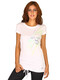

In [36]:
example = sample_results[0]
example[0].get_value()

In [37]:
# Prepare utility function to display sample results

import matplotlib.pyplot as plt
import numpy as np

def display_image_matrix(items, top):
    # Constants for the layout
    columns = 5
    rows = int(np.ceil(top / columns))

    # Create subplots
    fig, ax_arr = plt.subplots(rows, columns, figsize=(15, 3 * rows))
    fig.suptitle("Displaying images", fontsize=20)
    ax_arr = ax_arr.flatten() # Flatten the array of axes, in case of a single row

    # Plot images
    for i in range(top):
        if i < len(items):  # Check to avoid index error if less items than top
            img = items[i][0].get_value()  # Retrieve the image
            true_class = items[i][1]
            preds = items[i][2].model_dump()
            pred_class = preds['pred_label']

            # Set image and title
            ax_arr[i].imshow(img)
            ax_arr[i].set_title(f"True: {true_class}\nPred: {pred_class}", fontsize=14, backgroundcolor='white')
            ax_arr[i].axis('off')  # Hide axes
        else:
            ax_arr[i].axis('off')  # Hide unused subplots

    # Adjust layout and padding
    plt.tight_layout(pad=2.0)
    plt.show()

## Explore Low Confidence Mistakes

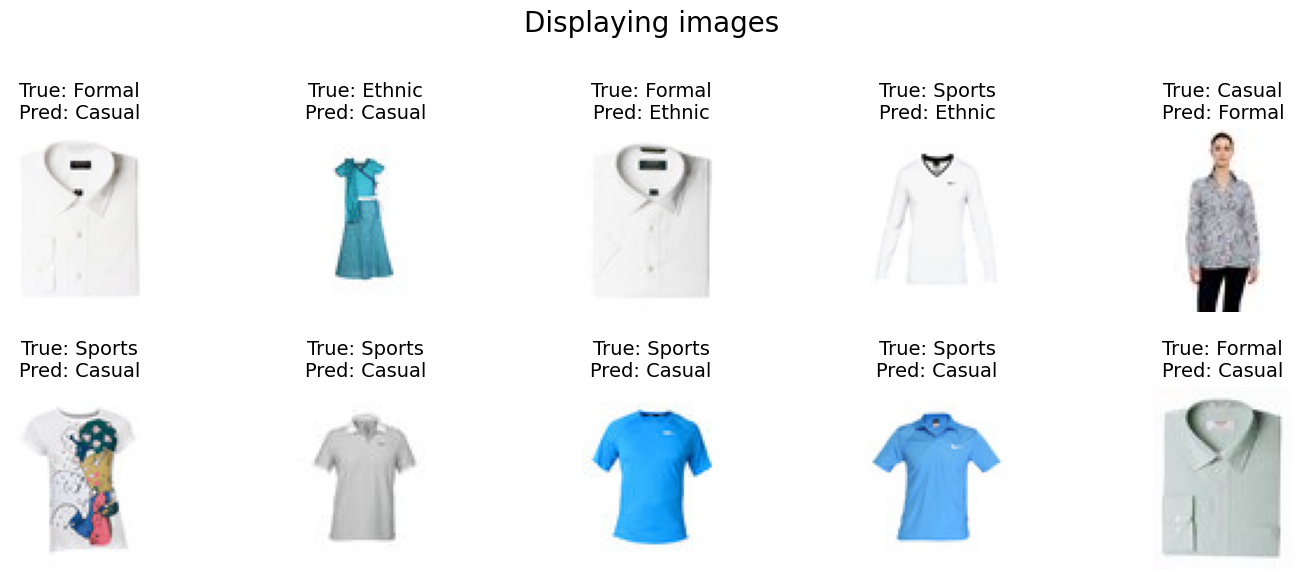

In [38]:
# Low Confidence Mistakes

TOP = 10
# for item in low_conf_mist.limit(TOP).collect():
#     display(item[0].get_value())
    
items = low_conf_mist.limit(TOP).collect()
display_image_matrix(items, TOP)

## Explore High Confidence Mistakes

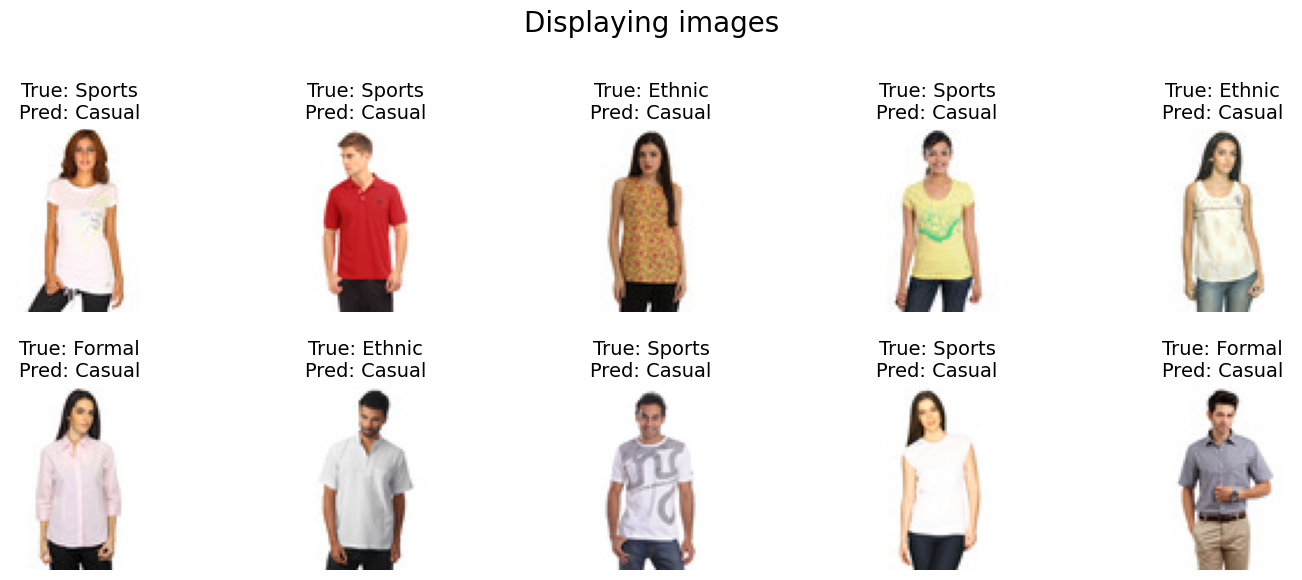

In [39]:
## How Confidence Mistakes

TOP = 10
# for item in high_conf_mist.limit(TOP).collect():
#     display(item[0].get_value())

items = high_conf_mist.limit(TOP).collect()
display_image_matrix(items, TOP)

## Explore Correct Predictions

In [40]:
correct_preds = (
    DataChain.from_dataset("fashion-predictions")
    .filter(C.usage == C.predictions.pred_label)
    .order_by(C.predictions.pred_proba.desc())
    .select("file", "usage", "predictions")
)

print(correct_preds.to_pandas().shape)
correct_preds.show(5)

(2983, 14)


,file.source,file.parent,file.name,file.size,file.version,file.etag,file.is_latest,file.last_modified,file.location,file.vtype,usage,predictions.pred_class,predictions.pred_proba,predictions.pred_label
0,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,10869.jpg,2231,,0x1.76bbcc6000000p+30,1,1970-01-01 00:00:00+00:00,None,,Casual,0,0.999869,Casual
1,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,3879.jpg,19040,,0x1.76bbcec000000p+30,1,1970-01-01 00:00:00+00:00,None,,Casual,0,0.999750,Casual
2,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,14951.jpg,2835,,0x1.76bbcc9000000p+30,1,1970-01-01 00:00:00+00:00,None,,Casual,0,0.999590,Casual
3,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,44865.jpg,4724,,0x1.76bbced800000p+30,1,1970-01-01 00:00:00+00:00,None,,Casual,0,0.999563,Casual
4,file:///,Users/mikhailrozhkov/dev/datachain/datachain/e...,8491.jpg,2392,,0x1.76bbcf3800000p+30,1,1970-01-01 00:00:00+00:00,None,,Casual,0,0.999547,Casual


[limited by 5 objects]


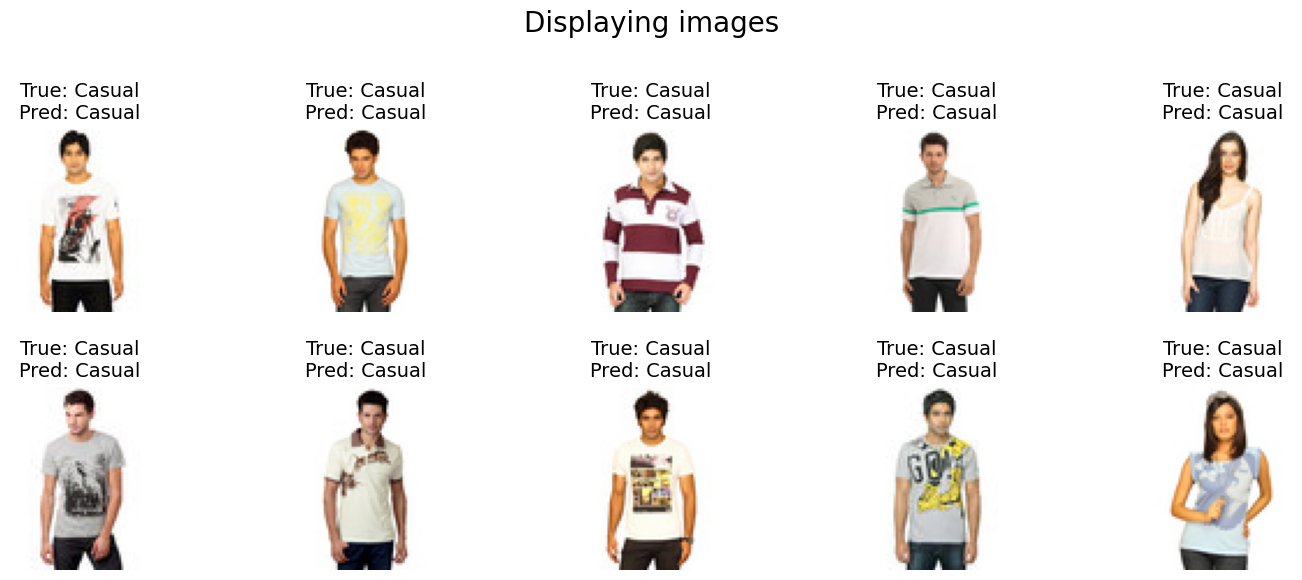

In [41]:
TOP = 10
# for item in high_conf_mist.limit(TOP).collect():
#     display(item[0].get_value())

items = correct_preds.limit(TOP).collect()
display_image_matrix(items, TOP)

# ☁️ Run in Studio (SaaS)

<a href="https://datachain.ai/">
    <img src="static/images/studio.png" alt="DataChain Studio SaaS" style="width: 600px;"/>
</a>

To run these examples in Studio, follow the guide.

1. Open Studio / YOUR_TEAM / `datasets` workspace
2. Create a new Python Script
3. Copy/paste scripts from this Jupyter Notebook
4. Specify Settings:
   - Computer vision dependencies
   - pre-trained model `model.pth`
   - import `train.py` module
5. Click the Run button


# 🎉 Summary 

**🌟 Congratulations! You've Successfully Completed the Inference Jobs with DataChain Tutorial! 🌟**

In this tutorial, you've gained a wealth of knowledge and skills that will elevate your computer vision projects to new heights. Let's recap the key topics covered:

1. 🔍 **Running Inference:** You unleashed the power of your model to make predictions on real-world fashion images.
2. 📊 **Saving Predictions:** You discovered how to save model predictions, probabilities, and true labels into a DataChain dataset for further analysis.
3. 🔍 **Analyzing Predictions:** You explored DataChain's querying and filtering capabilities to identify correct predictions, high-confidence mistakes, and low-confidence mistakes, gaining valuable insights into your model's performance.


Once again, congratulations on your incredible achievement! 

## What's Next?

Keep exploring, experimenting, and pushing the boundaries of what's possible in computer vision.  Check out the next parts of our tutorial series:
- 📚 Check other tutorials and User Guides
- 🔍 Try DataChain on your projects

By mastering these techniques, you'll be well on your way to building powerful and efficient computer vision pipelines with DataChain.

## Get Involved

We'd love to have you join our growing community of DataChain users and contributors! Here's how you can get involved:
- ⭐ Give us a star on [GitHub](https://github.com/iterative/dvcx) to show your support
- 🌐 Visit the [datachain.ai website](https://datachain.ai/) to learn more about our products and services
- 📞 Contact us to discuss how DataChain can help streamline your company's ML workflows
- 🙌 Follow us on social media for the latest updates and insights

Thanks for choosing DataChain, and happy coding! 😄